# Data Augmentation with Cutmix

## [Introduction](https://keras.io/examples/vision/cutmix/)
**CutMix** is a data augmentation technique that addresses the issue of information loss and inefficiency present in regional dropout strategies. Instead of removing pixels and filling them with black or grey pixels or Gaussian noise, you replace the removed regions with a patch from another image, while the ground truth labels are mixed proportionally to the number of pixels of combined images. CutMix was proposed in [CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/pdf/1905.04899.pdf) (Yun et al., 2019)

It's implemented via the following formulas:

$$
\overline{x} = Mx_{i} + (1 - M)x_{i}
$$
$$
\overline{y} = \lambda y_{i} + (1 - \lambda)y_{i}
$$


where `M` is the binary mask which indicates the cutout and the fill-in regions from the two randomly drawn images and `λ` (in `[0, 1]`) is drawn from a [`Beta(α, α)` distribution](https://en.wikipedia.org/wiki/Beta_distribution)

The coordinates of bounding boxes are:
$$
B = (r_{x},r_{y},r_{w},r_{h})
$$


which indicates the cutout and fill-in regions in case of the images. The bounding box sampling is represented by:

$$
r_{x} \sim \cup(0, W), r_{w}  =  W\sqrt{1-\lambda}
$$
$$
r_{y} \sim \cup(0, H), r_{h}  =  H\sqrt{1-\lambda}
$$

where `rx`, `ry` are randomly drawn from a uniform distribution with upper bound.

---

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## Read Files

In [2]:
def_front = glob.glob('/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/train/def_front/*.*')
ok_front = glob.glob('/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/train/ok_front/*.*')

In [3]:
data = []
labels = []

In [4]:
for i in def_front:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (32,32))
    image=np.array(image)
    data.append(image)
    temp = [0]
    labels.append(temp)

for i in ok_front:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (32,32))
    image=np.array(image)
    data.append(image)
    temp = [1]
    labels.append(temp)

In [5]:
data = np.array(data)
labels = np.array(labels, dtype=np.uint8)

## Split dataset

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [7]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

class_names = [
    "def_front",
    "ok_front"
]

(5306, 32, 32, 3)
(5306, 2)
(1327, 32, 32, 3)
(1327, 2)


In [8]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 32

In [9]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label

## Shuffle dataset

In [10]:
train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))


val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

val_ds = (
    val_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

2022-07-16 05:42:12.717994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Cutmix Function

In [11]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

## Preview cutmix images

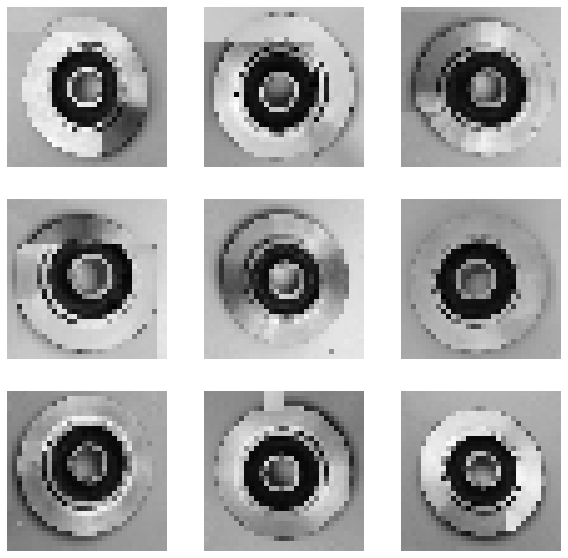

In [12]:
# Create the new dataset using our `cutmix` utility
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
plt.title("Data Augmentation using Cutmix")
for i in range(9):
    plt.style.use('dark_background')
    ax = plt.subplot(3, 3, i + 1)
    # plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

# plt.savefig(r"C:\Users\PiyushAnand\Desktop\CNN\images\cutmix.jpg")

## Build Model

In [13]:

def resnet_layer(
    inputs,
    num_filters=16,
    kernel_size=3,
    strides=1,
    activation="relu",
    batch_normalization=True,
    conv_first=True,
):
    conv = keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        strides=strides,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=keras.regularizers.l2(1e-4),
    )
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v20(input_shape, depth, num_classes=2):
    if (depth - 2) % 6 != 0:
        raise ValueError("depth should be 6n+2 (eg 20, 32, 44 in [a])")
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = keras.layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(
                    inputs=x,
                    num_filters=num_filters,
                    kernel_size=1,
                    strides=strides,
                    activation=None,
                    batch_normalization=False,
                )
            x = keras.layers.add([x, y])
            x = keras.layers.Activation("relu")(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = keras.layers.AveragePooling2D(pool_size=8)(x)
    y = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(
        num_classes, activation="softmax", kernel_initializer="he_normal"
    )(y)

    # Instantiate model.
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model

## Train Model

In [14]:
def training_model():
    return resnet_v20((32, 32, 3), 20)


initial_model = training_model()
initial_model.save_weights("initial_weights2.h5")

In [15]:
# with tpu_strategy.scope():
model = training_model()
model.load_weights("initial_weights2.h5")

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_cmu, validation_data=val_ds, epochs=15)

Epoch 1/15
166/166 [==============================] - 68s 389ms/step - loss: 0.6295 - accuracy: 0.8134 - val_loss: 2.5788 - val_accuracy: 0.4182
Epoch 2/15
166/166 [==============================] - 68s 408ms/step - loss: 0.5460 - accuracy: 0.8692 - val_loss: 0.5632 - val_accuracy: 0.8056
Epoch 3/15
166/166 [==============================] - 54s 326ms/step - loss: 0.5147 - accuracy: 0.8735 - val_loss: 0.3062 - val_accuracy: 0.9465
Epoch 4/15
166/166 [==============================] - 58s 348ms/step - loss: 0.5041 - accuracy: 0.8920 - val_loss: 0.3160 - val_accuracy: 0.9766
Epoch 5/15
166/166 [==============================] - 58s 346ms/step - loss: 0.4828 - accuracy: 0.8948 - val_loss: 0.2563 - val_accuracy: 0.9797
Epoch 6/15
166/166 [==============================] - 60s 359ms/step - loss: 0.4636 - accuracy: 0.8990 - val_loss: 0.4468 - val_accuracy: 0.8606
Epoch 7/15
166/166 [==============================] - 60s 358ms/step - loss: 0.4421 - accuracy: 0.9090 - val_loss: 0.6235 - val_ac

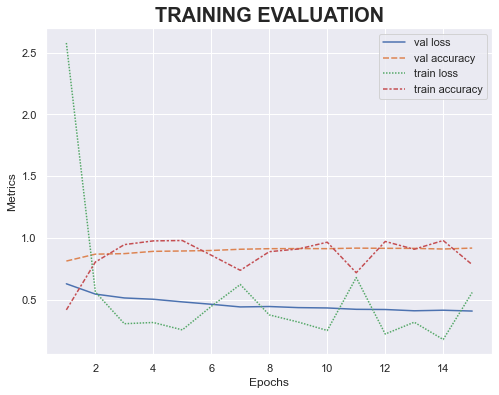

In [16]:
import seaborn as sns
sns.set()
plt.subplots(figsize = (8, 6))
sns.lineplot(data = pd.DataFrame(model.history.history,
                                 index = range(1, 1+len(model.history.epoch))))
plt.title("TRAINING EVALUATION", fontweight = "bold", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

## Test on test dataset

In [17]:
def_front_test = glob.glob('/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/test/def_front/*.*')
ok_front_test = glob.glob('/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/test/ok_front/*.*')

data_test = []
labels_test = []

for i in def_front:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (32,32))
    image=np.array(image)
#     labels.append(0)
    data_test.append(image)
    temp = [0]
    labels_test.append(temp)

for i in ok_front:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (32,32))
    image=np.array(image)
    data_test.append(image)
#     labels.append(1)
    temp = [1]
    labels_test.append(temp)

data_test = np.array(data)
labels_test = np.array(labels, dtype=np.uint8)

labels_test = tf.keras.utils.to_categorical(labels_test, num_classes=2)

test_ds = tf.data.Dataset.from_tensor_slices((data_test, labels_test))

test_ds = (
    test_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [18]:
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

208/208 [==============================] - 18s 86ms/step - loss: 0.4801 - accuracy: 0.8177
Test accuracy: 81.77%


## Test Accuracy
Accuracy : 81%

In [19]:
model.save('cutmix')

INFO:tensorflow:Assets written to: cutmix/assets


INFO:tensorflow:Assets written to: cutmix/assets


## Predict sample for one image

In [25]:
model_cutmix = tf.keras.models.load_model("cutmix")

In [42]:
image=tf.keras.preprocessing.image.load_img("/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/test/def_front/cast_def_0_242.jpeg", color_mode='rgb', target_size= (32,32))
image=np.array(image)
image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
image = np.reshape(image, (-1, 32, 32, 3))
image = tf.image.convert_image_dtype(image, tf.float32) / 255.0

In [43]:
pred = model_cutmix.predict(image)
pred

1/1 [==============================] - 0s 29ms/step


array([[0.8911149 , 0.10888514]], dtype=float32)

In [44]:
image=tf.keras.preprocessing.image.load_img("/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/test/ok_front/cast_ok_0_16.jpeg", color_mode='rgb', target_size= (32,32))
image=np.array(image)
image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
image = np.reshape(image, (-1, 32, 32, 3))
image = tf.image.convert_image_dtype(image, tf.float32) / 255.0

In [45]:
pred = model_cutmix.predict(image)
pred

1/1 [==============================] - 0s 35ms/step


array([[0.00758096, 0.9924191 ]], dtype=float32)